In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shakespear-sonnet/shakespear_sonnet.txt


# **Let's import required libraries**

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 

Now read the file

In [17]:
data = open('../input/shakespear-sonnet/shakespear_sonnet.txt').read()
data


"FROM fairest creatures we desire increase,\nThat thereby beauty's rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou, contracted to thine own bright eyes,\nFeed'st thy light'st flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThyself thy foe, to thy sweet self too cruel.\nThou that art now the world's fresh ornament\nAnd only herald to the gaudy spring,\nWithin thine own bud buriest thy content\nAnd, tender churl, makest waste in niggarding.\nPity the world, or else this glutton be,\nTo eat the world's due, by the grave and thee.\nWhen forty winters shall beseige thy brow,\nAnd dig deep trenches in thy beauty's field,\nThy youth's proud livery, so gazed on now,\nWill be a tatter'd weed, of small worth held:\nThen being ask'd where all thy beauty lies,\nWhere all the treasure of thy lusty days,\nTo say, within thine own deep-sunken eyes,\nWere an all-eating shame and thriftless praise.\nHow much mor

*Let's split the data and convert the corpus in lower case*

In [18]:
corpus = data.lower().split("\n")
corpus

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,',
 'within thine own bud buriest thy content',
 'and, tender churl, makest waste in niggarding.',
 'pity the world, or else this glutton be,',
 "to eat the world's due, by the grave and thee.",
 'when forty winters shall beseige thy brow,',
 "and dig deep trenches in thy beauty's field,",
 "thy youth's proud livery, so gazed on now,",
 "will be a tatter'd weed, of small worth held:",
 "then being ask'd where all thy beauty lies,",
 'where all the treasure of thy lusty days,',
 'to say, within thine own deep-sunken eyes,',

Now tokenize the data and find the total number of words.

In [24]:
oov_tok = "<OOV>"
vocab_size=20000
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

**Now we will create token list using tokenizer. It will convert a line of text to list of token representing words.**
* Example: In the town of athy ===> [4 2 66 867 68]

**Then we iterate over list of tokens and create n-grams sequences**:
* Example: 1st two word 1st sequence
         1st three word 2nd sequence 
         1st four words 3rd sequence
         .....
         ..... so on.
         
**Input sequences are simply the sentences being broken into phrases**

In [25]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

Now let's find out length of longest sentence in the corpus

In [27]:
max_sequence_len = max([len(x) for x in input_sequences])
print(max_sequence_len)

11


Let's pad all sequences to same length and change it to array

In [28]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Let's create predictor and label i.e., we extract all of input sequence as predictor and leave the last character as label.

In [30]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

Now perform one-hot encoding of labels using keras utility to convert a list to a catorical.

In [31]:
label = ku.to_categorical(label, num_classes=total_words)

Let's apply model:
* Embeddings with 100 dimensions
* Multi layer LSTM 
* kernel regularizer l2 with 0.01 learning rate

In [32]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321200    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1606)              162206    
_________________________________________________________________
dense_1 (Dense)              (None, 3212)              5161684   
Total params: 6,106,690
Trainable params: 6,106,690
Non-trainable params: 0
______________________________________________

Let's fit with model using 100 epochs

In [33]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 33s 68ms/step - loss: 6.9060 - accuracy: 0.0220
Epoch 2/100
484/484 [==============================] - 32s 67ms/step - loss: 6.5019 - accuracy: 0.0222
Epoch 3/100
484/484 [==============================] - 33s 67ms/step - loss: 6.3971 - accuracy: 0.0263
Epoch 4/100
484/484 [==============================] - 32s 66ms/step - loss: 6.2706 - accuracy: 0.0301
Epoch 5/100
484/484 [==============================] - 33s 67ms/step - loss: 6.1735 - accuracy: 0.0347
Epoch 6/100
484/484 [==============================] - 32s 66ms/step - loss: 6.0889 - accuracy: 0.0389
Epoch 7/100
484/484 [==============================] - 33s 67ms/step - loss: 6.0086 - accuracy: 0.0416
Epoch 8/100
484/484 [==============================] - 33s 67ms/step - loss: 5.9187 - accuracy: 0.0435
Epoch 9/100
484/484 [==============================] - 33s 68ms/step - loss: 5.8128 - accuracy: 0.0532
Epoch 10/100
484/484 [==============================] - 32s 66ms/step - l

484/484 [==============================] - 33s 67ms/step - loss: 1.3919 - accuracy: 0.7619
Epoch 80/100
484/484 [==============================] - 32s 67ms/step - loss: 1.3681 - accuracy: 0.7646
Epoch 81/100
484/484 [==============================] - 33s 68ms/step - loss: 1.3512 - accuracy: 0.7678
Epoch 82/100
484/484 [==============================] - 33s 69ms/step - loss: 1.3294 - accuracy: 0.7739
Epoch 83/100
484/484 [==============================] - 33s 69ms/step - loss: 1.3227 - accuracy: 0.7694
Epoch 84/100
484/484 [==============================] - 38s 79ms/step - loss: 1.3121 - accuracy: 0.7759
Epoch 85/100
484/484 [==============================] - 33s 69ms/step - loss: 1.3057 - accuracy: 0.7723
Epoch 86/100
484/484 [==============================] - 32s 66ms/step - loss: 1.2806 - accuracy: 0.7786
Epoch 87/100
484/484 [==============================] - 33s 67ms/step - loss: 1.2588 - accuracy: 0.7848
Epoch 88/100
484/484 [==============================] - 34s 70ms/step - loss:

Let's plot the graph and visualize

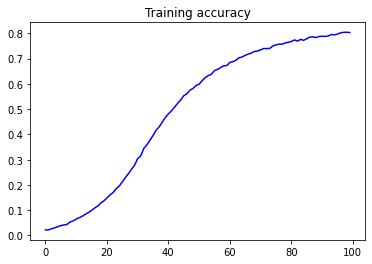

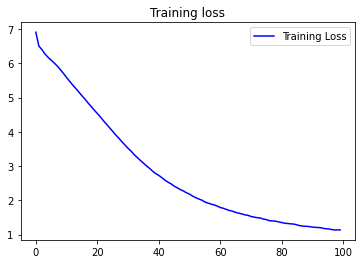

In [34]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

Now predict the word of Shakespeare

In [37]:
seed_text = "thereby beauty's rose"
next_words = 5
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

thereby beauty's rose might never die still long
